<a href="https://colab.research.google.com/github/gautaman8/healthcare-entity/blob/main/Assignment_identifying_entities_in_healthcare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

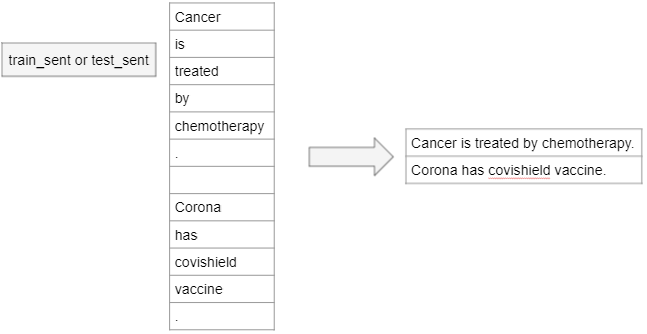

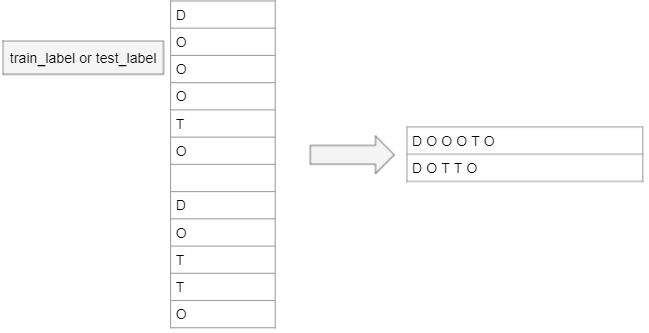

### Load the test data from google drive

In [ ]:
!pip install gdown

In [19]:
folder_url =  "https://drive.google.com/drive/folders/1u7b5jRIBTavHI9ITZrqE7BF93_3w-o2a"

In [56]:
# Download all the files from the public folder in google drive.
from google.colab import drive

# Flush the drive to ensure data is mounted correctly
drive.flush_and_unmount()

# Copy the test and train data to /healthcare_data folder in your Gdrive
drive.mount('/healthcare_data', force_remount=True)


Mounted at /healthcare_data


In [64]:
test_sent_file = open('/healthcare_data/MyDrive/healthcare_data/test_sent', 'r')
test_label_file = open('/healthcare_data/MyDrive/healthcare_data/test_label', 'r')
train_sent_file = open('/healthcare_data/MyDrive/healthcare_data/train_sent', 'r')
train_label_file = open('/healthcare_data/MyDrive/healthcare_data/train_label', 'r')


In [65]:
test_sent_data = test_sent_file.read()
test_label_data = test_label_file.read()
train_sent_data = train_sent_file.read()
train_label_data = train_label_file.read()

### Count the number of sentences in the processed train and test dataset

In [81]:
# Method to count the number of sentences in a file

def count_sentence(file):
  # file.seek(0,0)
  # contents = file.read()
  sentences = file.split('\n\n')
  # sentences = sentence.replace('\n', ' ')
  return len(sentences)

def extract_sentence(file):
  sentences = file.split('\n\n')
  sentences = [sentence.replace('\n', ' ') for sentence in sentences]
  return sentences

In [76]:
# Sentence count for test_sent
print(f"Sentence count for test_sent {count_sentence(test_sent_data)}")
# Sentence count for train_sent
print(f"Sentence count for train_sent {count_sentence(train_sent_data)}")

Sentence count for test_sent 1057
Sentence count for train_sent 2600


### Count the number of lines of labels in the processed train and test dataset.

In [77]:
# Sentence count for test_sent
print(f"Sentence count for test_label {count_sentence(test_label_data)}")
# Sentence count for train_sent
print(f"Sentence count for train_label {count_sentence(train_label_data)}")

Sentence count for test_label 1057
Sentence count for train_label 2600


The values match well between labels and sentences in both test and train dataset.

In [127]:
test_sentence_list = extract_sentence(test_sent_data)
train_sentence_list = extract_sentence(train_sent_data)

In [128]:
print(len(test_sentence_list))
# loading correctly as expected

1057


In [111]:
test_label_list = extract_sentence(test_label_data)
train_label_list = extract_sentence(train_label_data)

In [119]:

test_label_split = [i.split(' ') for i in test_label_list]
train_label_split = [i.split(' ') for i in train_label_list]

In [131]:
test_data = list(zip(test_sentence_list, test_label_split))
train_data = list(zip(train_sentence_list, train_label_split))

In [133]:
print(train_data[0])

('All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


### Count the number of lines of labels in the processed train and test dataset.

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [44]:
!pip install spacy

In [91]:
import spacy
nlp = spacy.load('en_core_web_sm')
from collections import Counter

In [92]:
# Function to get POS frequency count
def get_pos_frequency(sentences):
    # Initialize counters for NOUN and PROPN
    noun_counter = Counter()
    propn_counter = Counter()

    # Process each sentence
    for sentence in sentences:
        doc = nlp(sentence)
        # Count NOUN and PROPN in the current sentence
        noun_counter.update([token.text.lower() for token in doc if token.pos_ == "NOUN"])
        propn_counter.update([token.text.lower() for token in doc if token.pos_ == "PROPN"])

    return noun_counter, propn_counter

In [94]:
# Doing this analysis for test data
noun_frequency, propn_frequency = get_pos_frequency(test_sentence_list)
print(f"NOUN frequency for test data: {noun_frequency}")
print(f"PROPN frequency for test data: {propn_frequency}")

NOUN frequency for test data: Counter({'patients': 141, 'treatment': 93, '%': 86, 'cancer': 66, 'therapy': 55, 'study': 52, 'cell': 41, 'disease': 37, 'gene': 34, 'results': 33, 'group': 31, 'women': 30, 'lung': 29, 'effects': 28, 'analysis': 27, 'cases': 25, 'effect': 24, 'risk': 23, 'response': 23, 'chemotherapy': 23, 'age': 22, 'p': 22, 'rate': 21, 'use': 21, 'control': 20, 'surgery': 20, 'evidence': 19, 'year': 19, 'mutations': 18, 'term': 18, 'conclusions': 17, 'children': 17, 'hypertension': 17, 'protein': 17, 'management': 16, 'cells': 16, 'data': 15, 'case': 15, 'patient': 15, 'survival': 15, 'studies': 15, 'combination': 15, 'factors': 14, 'method': 14, 'trials': 14, 'stage': 14, 'carcinoma': 14, 'alpha': 14, 'pain': 14, 'heart': 14, 'years': 13, 'growth': 13, 'placebo': 13, 'time': 13, 'blood': 13, 'dose': 13, 'rates': 12, 'role': 12, 'radiotherapy': 12, '#': 12, 'pregnancy': 12, 'outcome': 12, 'days': 12, 'syndrome': 12, 'factor': 12, 'min': 12, 'percent': 12, 'failure': 12,

In [99]:
# Doing this analysis for train data
noun_frequency_train, propn_frequency_train = get_pos_frequency(test_sentence_list)
print(f"NOUN frequency for train data: {noun_frequency_train}")
print(f"PROPN frequency for train data: {propn_frequency_train}")

NOUN frequency for train data: Counter({'patients': 141, 'treatment': 93, '%': 86, 'cancer': 66, 'therapy': 55, 'study': 52, 'cell': 41, 'disease': 37, 'gene': 34, 'results': 33, 'group': 31, 'women': 30, 'lung': 29, 'effects': 28, 'analysis': 27, 'cases': 25, 'effect': 24, 'risk': 23, 'response': 23, 'chemotherapy': 23, 'age': 22, 'p': 22, 'rate': 21, 'use': 21, 'control': 20, 'surgery': 20, 'evidence': 19, 'year': 19, 'mutations': 18, 'term': 18, 'conclusions': 17, 'children': 17, 'hypertension': 17, 'protein': 17, 'management': 16, 'cells': 16, 'data': 15, 'case': 15, 'patient': 15, 'survival': 15, 'studies': 15, 'combination': 15, 'factors': 14, 'method': 14, 'trials': 14, 'stage': 14, 'carcinoma': 14, 'alpha': 14, 'pain': 14, 'heart': 14, 'years': 13, 'growth': 13, 'placebo': 13, 'time': 13, 'blood': 13, 'dose': 13, 'rates': 12, 'role': 12, 'radiotherapy': 12, '#': 12, 'pregnancy': 12, 'outcome': 12, 'days': 12, 'syndrome': 12, 'factor': 12, 'min': 12, 'percent': 12, 'failure': 12

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [100]:
combined_frequency = propn_frequency + noun_frequency + propn_frequency_train + noun_frequency_train

In [101]:
# Print the top 25 items
print("Top 25 combined NOUN and PROPN:")
for word, count in combined_frequency.most_common(25):
    print(f"{word}: {count}")

Top 25 combined NOUN and PROPN:
patients: 282
treatment: 188
%: 172
cancer: 134
therapy: 110
study: 108
cell: 82
disease: 80
group: 72
gene: 68
results: 66
women: 60
lung: 58
effects: 56
analysis: 54
p: 52
cases: 50
effect: 48
use: 46
risk: 46
response: 46
chemotherapy: 46
control: 44
age: 44
rate: 42


## Getting the features

### Write a code/function to get the features for a sentence

In [106]:
!pip install python-crfsuite

In [145]:
def word2features(sent, i):
    text = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': text.lower(),
        'word[-3:]': text[-3:],
        'word.isupper()': text.isupper(),
        'word.istitle()': text.istitle(),
        'word.isdigit()': text.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        text1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': text1.lower(),
            '-1:word.istitle()': text1.istitle(),
            '-1:word.isupper()': text1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True  # Mark the beginning of the sentence

    if i < len(sent)-1:
        text1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': text1.lower(),
            '+1:word.istitle()': text1.istitle(),
            '+1:word.isupper()': text1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True  # Mark the end of the sentence

    return features

### Write a code/function to get the labels of a sentence

In [146]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return sent

def sent2tokens(sent):
    return [token for token, label in sent]

## Build the CRF Model

In [144]:
from spacy.scorer import Scorer

In [147]:
train_docs = []
for text, labels in train_data:
    doc = nlp(text)
    train_docs.append(([(token.text, token.pos_) for token in doc], labels))

test_docs = []
for text, labels in test_data:
    doc = nlp(text)
    test_docs.append(([(token.text, token.pos_) for token in doc], labels))


In [148]:
X_train = [sent2features(s) for s in train_docs]
y_train = [sent2labels(s) for s in train_docs]

X_test = [sent2features(s) for s in test_docs]
y_test = [sent2labels(s) for s in test_docs]

AttributeError: ignored

In [154]:
import spacy
import pycrfsuite
from spacy.scorer import Scorer

# # Load the English language model
# nlp = spacy.load("en_core_web_sm")

# # Training data with labels
# train_data = [
#     ("This is a sample sentence.", ['O', 'T', 'T', 'O', 'T', 'E']),
#     # Add more training data as needed
# ]

# # Testing data with labels
# test_data = [
#     ("Another sentence for testing.", ['O', 'O', 'O', 'O', 'O', 'O']),
#     # Add more testing data as needed
# ]

# Function to extract features for each word
def word2features(sent, i):
    text, postag = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': text.lower(),
        'word[-3:]': text[-3:],
        'word.isupper()': text.isupper(),
        'word.istitle()': text.istitle(),
        'word.isdigit()': text.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        text1, postag1 = sent[i-1]
        features.update({
            '-1:word.lower()': text1.lower(),
            '-1:word.istitle()': text1.istitle(),
            '-1:word.isupper()': text1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True  # Mark the beginning of the sentence

    if i < len(sent)-1:
        text1, postag1 = sent[i+1]
        features.update({
            '+1:word.lower()': text1.lower(),
            '+1:word.istitle()': text1.istitle(),
            '+1:word.isupper()': text1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True  # Mark the end of the sentence

    return features

# Function to extract features and labels for a sentence
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent[0]))]

def sent2labels(sent):
    return sent[1]

def sent2tokens(sent):
    return [token for token, label in sent[0]]

# Convert training data to spacy Doc objects
train_docs = []
for text, labels in train_data:
    doc = nlp(text)
    tokens_with_pos = [(token.text, token.pos_) for token in doc]
    train_docs.append((tokens_with_pos, labels))

# Convert testing data to spacy Doc objects
test_docs = []
for text, labels in test_data:
    doc = nlp(text)
    tokens_with_pos = [(token.text, token.pos_) for token in doc]
    test_docs.append((tokens_with_pos, labels))

# Convert the training set to CRF features and labels
X_train = [sent2features(s) for s in train_docs]
y_train = [sent2labels(s) for s in train_docs]

# Convert the testing set to CRF features and labels
X_test = [sent2features(s) for s in test_docs]
y_test = [sent2labels(s) for s in test_docs]

# Train CRF model
trainer = pycrfsuite.Trainer()
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

trainer.set_params({
    'c1': 1.0,
    'c2': 1e-3,
    'max_iterations': 50,
    'feature.possible_transitions': True,
})

trainer.train('pos_crf_model.crfsuite')

# Evaluate CRF model
tagger = pycrfsuite.Tagger()
tagger.open('pos_crf_model.crfsuite')

# Test the model on the testing set
y_pred = [tagger.tag(xseq) for xseq in X_test]

# Calculate and print the accuracy
scorer = Scorer()
for y_true, y_pred_i in zip(y_test, y_pred):
    scorer.score(y_true, y_pred_i)

print(f'Accuracy: {scorer.scores["accuracy"]:.2%}')


ValueError: ignored

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

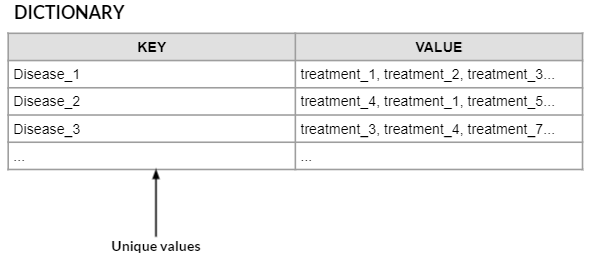

### Predict the treatment for the disease name: 'hereditary retinoblastoma'